In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update(mpl.rcParamsDefault)
import os
import math
import cmath


# functions

In [2]:
def open_file(path):
    
    file=np.load(path)
    
    resp=file['resp']
    paramsarray=file['paramsarray']
    missingqs=file['missingqs']
    twochains=file['twochains']
    nodes=file['final_nodes']
    
    return resp,paramsarray,missingqs,twochains,nodes

In [3]:
def open_file_new(path):
    
    file=np.load(path)
    
    resp=file['resp']
    paramsarray=file['paramsarray']
    
    return resp,paramsarray

In [4]:
def magnetization(response,filter_E):
    
    if filter_E==True:
        #find the minimum energy
        energies=[]
        for i in range(len(response)):
            energy=response[i][1]
            energies.append(energy)
        minE=min(energies)    
        #count only runs in the response that have the minimum energy
        filtered_resp=[]
        for j in range(len(response)):
            if response[j][1]==minE:
                filtered_resp.append(response[i])
        response=filtered_resp       
        
    mags=[]
    for i in range(len(response)):
        run_pms=response[i][0]
        mags.append(np.mean(run_pms))

    avgmag=np.mean(mags)
    sdmag=np.std(mags)

    return mags,avgmag,sdmag

In [5]:
def chain_breaks(response,twochains,nodes):
    broken_runs=[]
    brokens=[]
    for run in range(len(resp)):
        pms=resp[run][0]

        broken=[]
        for chain in twochains:
            q0=chain[0]
            q1=chain[1]
            index0=sorted(list(nodes)).index(q0)
            index1=sorted(list(nodes)).index(q1)

            pm0=pms[index0]
            pm1=pms[index1]

            if pm0!=pm1:
                broken.append((q0,q1))
                
        brokens.append(broken)
        if len(broken)>0:
            broken_runs.append(run)
        
    Nbrokens=[len(broken) for broken in brokens]
    avgbrokens=np.mean(Nbrokens)
    return brokens,avgbrokens,broken_runs 

In [6]:
#this function checks for chain breaks in a single configuration
def chain_break_single(config,twochains,nodes):
    pms=config

    broken=[]
    for chain in twochains:
        q0=chain[0]
        q1=chain[1]
        index0=sorted(list(nodes)).index(q0)
        index1=sorted(list(nodes)).index(q1)

        pm0=pms[index0]
        pm1=pms[index1]

        if pm0!=pm1:
            broken.append((q0,q1))
        
    Nbrokens=len(broken)
    return broken,Nbrokens  

In [7]:
def checkabc(node):
    print(node)
    if node in a:
        print('a')
    if node in b:
        print('b')
    if node in c:
        print('c')

In [8]:
def phi_tri(config, p, q, r, nodes):

    p_vals = []
    for qubit in p:
        index = np.where(nodes == qubit)[0][0]
        pm = config[index]
        p_vals.append(pm)
    p_sum = np.sum(p_vals)
    q_vals = []
    for qubit in q:
        index = np.where(nodes == qubit)[0][0]
        pm = config[index]
        q_vals.append(pm)
    q_sum = np.sum(q_vals)
    r_vals = []
    for qubit in r:
        index = np.where(nodes == qubit)[0][0]
        pm = config[index]
        r_vals.append(pm)
    r_sum = np.sum(r_vals)
    
    omega=np.exp(2*1j*np.pi/3)
    phi = (3 / 56) * (p_sum + omega * q_sum + (omega**2) * r_sum)

    phi_abs = np.sqrt(np.real(phi)**2 + np.imag(phi)**2)

    return phi, phi_abs

In [9]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

# periodic kagome - new stuff

In [10]:
sublatt_dict={0: 'A', 7: 'B', 8: 'A', 9: 'A', 10: 'A', 11: 'A', 12: 'B', 13: 'B', 14: 'B', 15: 'B', 24: 'B', 40: 'B', 41: 'B', 42: 'B', 43: 'B', 44: 'A', 45: 'A', 46: 'A', 47: 'A', 48: 'B', 49: 'B', 50: 'B', 51: 'B', 52: 'A', 53: 'A', 54: 'A', 55: 'A', 63: 'B', 64: 'B', 71: 'A', 72: 'A', 73: 'A', 74: 'A', 75: 'A', 76: 'B', 77: 'B', 78: 'B', 79: 'B', 80: 'A', 81: 'A', 82: 'A', 83: 'A', 84: 'B', 85: 'B', 86: 'B', 87: 'B', 88: 'B', 95: 'B', 96: 'A', 104: 'B', 105: 'B', 106: 'B', 107: 'B', 108: 'A', 109: 'A', 110: 'A', 111: 'A', 112: 'B', 113: 'B', 114: 'B', 115: 'B', 116: 'A', 117: 'A', 118: 'A', 119: 'A', 120: 'A', 127: 'A', 128: 'B', 135: 'B', 136: 'A', 137: 'A', 138: 'A', 139: 'A', 140: 'B', 141: 'B', 142: 'B', 143: 'B', 144: 'A', 145: 'A', 146: 'A', 147: 'A', 148: 'B', 149: 'B', 150: 'B', 152: 'B', 159: 'B', 160: 'A', 168: 'B', 169: 'B', 170: 'B', 171: 'B', 172: 'A', 173: 'A', 174: 'A', 175: 'A', 176: 'B', 177: 'B', 178: 'B', 179: 'B', 180: 'A', 181: 'A', 182: 'A', 183: 'A', 191: 'B', 200: 'A', 201: 'A', 202: 'A', 203: 'A', 204: 'B', 205: 'B', 206: 'B', 207: 'B', 208: 'A', 209: 'A', 210: 'A', 211: 'A', 212: 'B', 213: 'B', 214: 'B', 215: 'B', 216: 'B', 223: 'B', 232: 'B', 233: 'B', 234: 'B', 235: 'B', 236: 'A', 237: 'A', 238: 'A', 239: 'A', 240: 'B', 241: 'B', 242: 'B', 243: 'B', 244: 'A', 245: 'A', 246: 'A', 247: 'A', 264: 'A', 265: 'A', 266: 'A', 267: 'A', 268: 'B', 269: 'B', 270: 'B', 271: 'B', 296: 'C', 297: 'C', 298: 'C', 299: 'C', 300: 'C', 301: 'C', 302: 'C', 303: 'C', 307: 'A', 310: 'A', 311: 'A', 318: 'B', 319: 'B', 324: 'A', 336: 'C', 337: 'C', 338: 'C', 339: 'C', 340: 'C', 341: 'C', 342: 'C', 343: 'C', 360: 'C', 361: 'C', 362: 'C', 363: 'C', 364: 'C', 365: 'C', 366: 'C', 367: 'C', 400: 'C', 401: 'C', 402: 'C', 403: 'C', 404: 'C', 405: 'C', 406: 'C', 407: 'C', 424: 'C', 425: 'C', 426: 'C', 427: 'C', 428: 'C', 429: 'C', 430: 'C', 431: 'C', 464: 'C', 465: 'C', 466: 'C', 467: 'C', 468: 'C', 469: 'C', 470: 'C', 471: 'C', 488: 'C', 489: 'C', 490: 'C', 491: 'C', 492: 'C', 493: 'C', 494: 'C', 495: 'C', 528: 'C', 529: 'C', 530: 'C', 531: 'C', 532: 'C', 533: 'C', 534: 'C', 535: 'C', 536: 'A', 537: 'A', 538: 'A', 539: 'A', 543: 'A', 550: 'A', 551: 'B', 552: 'C', 553: 'C', 554: 'C', 555: 'C', 556: 'C', 557: 'C', 558: 'C', 559: 'C'}
toremove=[
    63,191,551,223,159,95,7,
    324,120,310,311,307,160,96,0
]
sublatt_dict_trunc=sublatt_dict.copy()
for qubit in toremove:
    sublatt_dict_trunc.pop(qubit)
    
toremove2=[71,556,127,557,550,558,543,559,539,555,538,554,537,553,536,552,
           64,300,128,301,318,302,319,303,216,299,152,298,88, 297,24, 296,
           87,135,215,271,207,143,79, 15, 80, 144,208,264,200,136,72,8

]
sublatt_dict_truncer=sublatt_dict_trunc.copy()
for qubit in toremove2:
    sublatt_dict_truncer.pop(qubit)

Alist=[]
Blist=[]
Clist=[]
for key in sublatt_dict_trunc.keys():
    if sublatt_dict_trunc[key] == "A":
        Alist.append(key)
    if sublatt_dict_trunc[key] == "B":
        Blist.append(key)
    if sublatt_dict_trunc[key] == "C":
        Clist.append(key)
print("number of points per sublattice")
print("A, B, C")
print(len(Alist),len(Blist),len(Clist))

Alist2=[]
Blist2=[]
Clist2=[]
for key in sublatt_dict_truncer.keys():
    if sublatt_dict_truncer[key] == "A":
        Alist2.append(key)
    if sublatt_dict_truncer[key] == "B":
        Blist2.append(key)
    if sublatt_dict_truncer[key] == "C":
        Clist2.append(key)
print("number of points per sublattice")
print("A, B, C")
print(len(Alist2),len(Blist2),len(Clist2))

number of points per sublattice
A, B, C
72 72 72
number of points per sublattice
A, B, C
56 56 56


In [11]:
allsites=sublatt_dict.keys()
allsites_down=sublatt_dict_trunc.keys()
allsites_down_good=sublatt_dict_truncer.keys()


In [12]:
twochains_period=[(204, 382), (220, 342), (45, 412), (93, 404), (30, 488), (14, 472), (238, 511), (286, 471), (143, 525), (123, 533), (239, 567), (279, 535), (252, 343), (268, 351), (135, 541), (24, 312), (88, 313), (152, 314), (216, 315), (319, 256), (318, 192), (128, 325), (64, 316), (536, 39), (537, 103), (538, 167), (539, 231), (543, 255), (550, 199), (71, 548), (0, 320), (324, 56), (96, 321), (120, 317), (160, 322), (310, 184), (307, 224), (311, 248), (7, 544), (63, 540), (95, 545), (159, 546), (191, 542), (223, 547), (551, 263)]
nodes_period=[0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 24, 30, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 63, 64, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 93, 95, 96, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 127, 128, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 159, 160, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 191, 192, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 220, 223, 224, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 252, 255, 256, 263, 264, 265, 266, 267, 268, 269, 270, 271, 279, 286, 296, 297, 298, 299, 300, 301, 302, 303, 307, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 324, 325, 336, 337, 338, 339, 340, 341, 342, 343, 351, 360, 361, 362, 363, 364, 365, 366, 367, 382, 400, 401, 402, 403, 404, 405, 406, 407, 412, 424, 425, 426, 427, 428, 429, 430, 431, 464, 465, 466, 467, 468, 469, 470, 471, 472, 488, 489, 490, 491, 492, 493, 494, 495, 511, 525, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 567]
all_couplers_from_site = [(0, 296), (0, 40), (7, 552), (7, 47), (8, 12), (8, 296), (8, 336), (8, 24), (9, 13), (9, 360), (9, 12), (9, 400), (10, 14), (10, 424), (10, 13), (10, 464), (11, 15), (11, 488), (11, 14), (11, 528), (12, 360), (12, 336), (13, 424), (13, 400), (14, 488), (14, 464), (15, 552), (15, 528), (15, 536), (24, 296), (40, 296), (40, 44), (40, 340), (41, 360), (41, 45), (41, 404), (41, 44), (42, 424), (42, 46), (42, 468), (42, 45), (43, 488), (43, 47), (43, 532), (43, 46), (44, 360), (44, 340), (45, 424), (45, 404), (46, 488), (46, 468), (47, 552), (47, 532), (48, 300), (48, 52), (48, 336), (48, 324), (49, 400), (49, 52), (49, 364), (49, 53), (50, 464), (50, 53), (50, 428), (50, 54), (51, 528), (51, 54), (51, 492), (51, 55), (52, 336), (52, 364), (53, 400), (53, 428), (54, 464), (54, 492), (55, 556), (55, 528), (55, 63), (63, 556), (64, 300), (64, 80), (71, 556), (71, 87), (72, 76), (72, 297), (72, 340), (72, 88), (73, 77), (73, 361), (73, 76), (73, 404), (74, 78), (74, 425), (74, 77), (74, 468), (75, 79), (75, 489), (75, 78), (75, 532), (76, 361), (76, 340), (77, 425), (77, 404), (78, 489), (78, 468), (79, 553), (79, 532), (79, 537), (80, 84), (80, 300), (80, 337), (81, 84), (81, 401), (81, 85), (81, 364), (82, 85), (82, 465), (82, 86), (82, 428), (83, 86), (83, 529), (83, 87), (83, 492), (84, 337), (84, 364), (85, 401), (85, 428), (86, 465), (86, 492), (87, 556), (87, 529), (88, 297), (95, 553), (95, 111), (96, 297), (96, 104), (104, 297), (104, 108), (104, 341), (105, 361), (105, 109), (105, 405), (105, 108), (106, 425), (106, 110), (106, 469), (106, 109), (107, 489), (107, 111), (107, 533), (107, 110), (108, 361), (108, 341), (109, 425), (109, 405), (110, 489), (110, 469), (111, 553), (111, 533), (112, 301), (112, 116), (112, 337), (112, 120), (113, 401), (113, 116), (113, 365), (113, 117), (114, 465), (114, 117), (114, 429), (114, 118), (115, 529), (115, 118), (115, 493), (115, 119), (116, 337), (116, 365), (117, 401), (117, 429), (118, 465), (118, 493), (119, 557), (119, 529), (120, 301), (127, 557), (127, 135), (128, 301), (128, 144), (135, 557), (135, 530), (135, 147), (136, 140), (136, 298), (136, 341), (136, 152), (137, 141), (137, 362), (137, 140), (137, 405), (138, 142), (138, 426), (138, 141), (138, 469), (139, 143), (139, 490), (139, 142), (139, 533), (140, 362), (140, 341), (141, 426), (141, 405), (142, 490), (142, 469), (143, 554), (143, 533), (143, 538), (144, 148), (144, 301), (144, 338), (145, 148), (145, 402), (145, 149), (145, 365), (146, 149), (146, 466), (146, 150), (146, 429), (147, 150), (147, 530), (147, 493), (148, 338), (148, 365), (149, 402), (149, 429), (150, 466), (150, 493), (152, 298), (159, 554), (159, 175), (160, 298), (160, 168), (168, 298), (168, 172), (168, 342), (169, 362), (169, 173), (169, 406), (169, 172), (170, 426), (170, 174), (170, 470), (170, 173), (171, 490), (171, 175), (171, 534), (171, 174), (172, 362), (172, 342), (173, 426), (173, 406), (174, 490), (174, 470), (175, 554), (175, 534), (176, 302), (176, 180), (176, 338), (176, 310), (177, 402), (177, 180), (177, 366), (177, 181), (178, 466), (178, 181), (178, 430), (178, 182), (179, 530), (179, 182), (179, 494), (179, 183), (180, 338), (180, 366), (181, 402), (181, 430), (182, 466), (182, 494), (183, 558), (183, 530), (183, 191), (191, 558), (200, 204), (200, 299), (200, 342), (200, 216), (201, 205), (201, 363), (201, 204), (201, 406), (202, 206), (202, 427), (202, 205), (202, 470), (203, 207), (203, 491), (203, 206), (203, 534), (204, 363), (204, 342), (205, 427), (205, 406), (206, 491), (206, 470), (207, 555), (207, 534), (207, 539), (208, 212), (208, 302), (208, 339), (208, 318), (209, 212), (209, 403), (209, 213), (209, 366), (210, 213), (210, 467), (210, 214), (210, 430), (211, 214), (211, 531), (211, 215), (211, 494), (212, 339), (212, 366), (213, 403), (213, 430), (214, 467), (214, 494), (215, 558), (215, 531), (215, 550), (216, 299), (223, 555), (223, 239), (232, 299), (232, 236), (232, 343), (232, 307), (233, 363), (233, 237), (233, 407), (233, 236), (234, 427), (234, 238), (234, 471), (234, 237), (235, 491), (235, 239), (235, 535), (235, 238), (236, 363), (236, 343), (237, 427), (237, 407), (238, 491), (238, 471), (239, 555), (239, 535), (240, 303), (240, 244), (240, 339), (240, 311), (241, 367), (241, 245), (241, 403), (241, 244), (242, 431), (242, 246), (242, 467), (242, 245), (243, 495), (243, 247), (243, 531), (243, 246), (244, 367), (244, 339), (245, 431), (245, 403), (246, 495), (246, 467), (247, 559), (247, 531), (247, 551), (264, 268), (264, 343), (264, 303), (264, 319), (265, 268), (265, 407), (265, 269), (265, 367), (266, 269), (266, 471), (266, 270), (266, 431), (267, 270), (267, 535), (267, 271), (267, 495), (268, 343), (268, 367), (269, 407), (269, 431), (270, 471), (270, 495), (271, 535), (271, 559), (271, 543), (299, 307), (300, 324), (302, 318), (302, 310), (303, 319), (303, 311), (536, 552), (537, 553), (538, 554), (539, 555), (543, 559), (550, 558), (551, 559)]

we need to create lists of the indices to measure

In [13]:
all_sites = []
for n in range(len(list(sublatt_dict.keys()))):
    qubit = list(sublatt_dict.keys())[n]
    index = np.where(np.array(nodes_period) == qubit)[0][0]
    all_sites.append(index)

all_down_triangles = []
for n in range(len(list(sublatt_dict_trunc.keys()))):
    qubit = list(sublatt_dict_trunc.keys())[n]
    index = np.where(np.array(nodes_period) == qubit)[0][0]
    all_down_triangles.append(index)

all_good_down_triangles = []
for n in range(len(list(sublatt_dict_truncer.keys()))):
    qubit = list(sublatt_dict_truncer.keys())[n]
    index = np.where(np.array(nodes_period) == qubit)[0][0]
    all_good_down_triangles.append(index)

In [14]:
list_sites_a = []
list_sites_b = []
actual_couples_to_measure = []
for n in range(len(list(sublatt_dict_truncer.keys()))):
    qubit = list(sublatt_dict_truncer.keys())[n]
    for tuple_couple in all_couplers_from_site:
        if qubit == tuple_couple[0] or qubit == tuple_couple[1]:
            actual_couples_to_measure.append(tuple_couple)

del_dup_couples = [*set(actual_couples_to_measure)]
for i in range(len(del_dup_couples)):
    asite = np.where(np.array(nodes_period) == del_dup_couples[i][0])[0][0]
    list_sites_a.append(asite)
    bsite = np.where(np.array(nodes_period) == del_dup_couples[i][1])[0][0]
    list_sites_b.append(bsite)

# process anneal pause quench

In [21]:
mainfolder = list(Path('./data/raw_apq_v3').glob('*'))
#mainfolder = list(Path('./data/raw_apq_zx').glob('*'))


# list of h values
h1list = []
# list of s values
slist = []

rep_list = []

list_of_folders = []

rep_file_names = []

for foldername in mainfolder:
    print(foldername)
    h1 = str(foldername).split('/')[-1].split('=')[-1]
    print("h1=",h1)
    h1list.append(h1)
    folderlist_h = list(foldername.glob('*'))
    list_of_folders.append(foldername)
    #print(folderlist_h)
    rep_file_names_h = []

    s_list_h=[]
    rep_list_h = []
    #take care of ds checkpoint folder
    for foldername_s in folderlist_h:
        folderlist_s = list(foldername_s.glob('*'))
        rep_file_names_h.append(folderlist_s)
        s = '0.' + str(foldername_s).split('/')[-1].split('.')[-1]
        #print("s=", s)
        s_list_h.append(float(s))
        rep_list_h.append(len(folderlist_s))

    rep_list.append(rep_list_h)
    s_list_h_arr = np.array(s_list_h)
    sort_index = np.argsort(s_list_h_arr)
    rep_file_names.append(rep_file_names_h)
    slist.append([s_list_h[sort_index[i]] for i in range(len(s_list_h_arr))])

data/raw_apq_v3/h=0.06613701696385046
h1= 0.06613701696385046
data/raw_apq_v3/h=0.19841105089155137
h1= 0.19841105089155137
data/raw_apq_v3/h=0.0
h1= 0.0
data/raw_apq_v3/h=0.3306850848192523
h1= 0.3306850848192523
data/raw_apq_v3/h=1.3227403392770092
h1= 1.3227403392770092
data/raw_apq_v3/h=0.13227403392770093
h1= 0.13227403392770093
data/raw_apq_v3/h=0.26454806785540186
h1= 0.26454806785540186
data/raw_apq_v3/h=0.9920552544577569
h1= 0.9920552544577569


In [24]:
import h5py
#where_to_save = "./data/processed_apq_zx/"
where_to_save = "./data/processed_apq_v3/"

folder_create = Path(where_to_save[:-1])
folder_create.mkdir(parents=True, exist_ok=True)


for k in range(len(list_of_folders)):
    #these are the h_folders
    folder_lookinto = list_of_folders[k]
    #range(len(slist))
    #folder_lookinto = "./data/raw_apq/h=2.116384542843215/"
    # avgbrokens = []
    # allEs = []
    # magseries1 = []
    # magseries2 = []
    # magseries3 = []
    # phiseries = []
    # Eclassical = []
    # slist_at_h=slist[k]

    h1_print_val = h1list[k]
    print("start with h=" + h1_print_val)

    for ls in range(len(slist_at_h)):
        #path_sp = Path(str(folder_lookinto) + "/sp=" + str(slist_at_h[ls]))
        path_sp = rep_file_names[k][ls]

        energies = []

        mags1 = []
        mags2 = []
        mags3 = []

        phis = []
        energies_classical = []

        broken_number = []

        #these are the repetitions
        for rep_i in range(len(path_sp)):
            file =  path_sp[rep_i]   
            name = os.path.basename(file)
            if name != 'regs.npz':
                try:
                    resp, paramsarray = open_file_new(file)
                    
                except ValueError:
                    pass

            #process those files
            resp_array = np.array(resp)

            broken = 0

            brokens, avgbroken, broken_runs = chain_breaks(
                resp, twochains_period, nodes_period)
            if len(broken_runs) > 0:
                broken += len(broken_runs)
            #avgbrokens.append(avgbroken)
            broken_number.append(broken)

            #next loop over all reads
            for m in range(resp_array.shape[0]):
                frequency = resp[m][2]

                for freq in range(frequency):
                    energies.append(resp[m][1])

                    arr = resp[m][0]

                    mag1 = np.mean(arr[all_sites])
                    mag2 = np.mean(arr[all_down_triangles])
                    mag3 = np.mean(arr[all_good_down_triangles])

                    mags1.append(mag1)
                    mags2.append(mag2)
                    mags3.append(mag3)

                    eclass = np.mean(np.multiply(arr[list_sites_a], arr[list_sites_b]))
                    energies_classical.append(eclass)

                    phi, phi_abs = phi_tri(arr, Alist, Blist, Clist,
                                            np.array(nodes_period))
                    phis.append(phi)

        # allEs.append(energies)

        # magseries1.append(mags1)
        # magseries2.append(mags2)
        # magseries3.append(mags3)

        # phiseries.append(phis)
        # Eclassical.append(energies_classical)
        # avgbrokens.append(broken_number)


        print("sp = " + str(slist_at_h[ls]) + " - done - number of broken runs:", broken)


        filename = where_to_save + "processed_h=" + h1_print_val + "sp = " + str(slist_at_h[ls]) + ".hdf5"

        try:
            os.remove(filename)
        except OSError:
            pass

        with h5py.File(Path(filename), "w") as f:
            f.create_dataset("slist", data = slist_at_h[ls])
            f.create_dataset("avg_broken", data = broken_number)
            f.create_dataset("energies", data = energies)
            f.create_dataset("good_down_triangle_magnetization", data = mags3)
            f.create_dataset("energy_classical", data = energies_classical)
            

    # print("done with h=" + h1_print_val)

    # filename_h = where_to_save + "processed_h=" + h1_print_val + ".hdf5"

    # try:
    #     os.remove(filename_h)
    # except OSError:
    #     pass

    # with h5py.File(Path(filename_h), "w") as f:
    #     f.create_dataset("slist", data = slist_at_h)
    #     f.create_dataset("avg_broken", data = avgbrokens)
    #     f.create_dataset("energies", data = allEs)
    #     f.create_dataset("all_magnetization", data = magseries1)
    #     f.create_dataset("good_down_triangle_magnetization", data = magseries3)

start with h=0.06613701696385046
sp = 0.1 - done - number of broken runs: 0
sp = 0.135 - done - number of broken runs: 0
sp = 0.17 - done - number of broken runs: 0
sp = 0.20500000000000002 - done - number of broken runs: 0
sp = 0.24000000000000002 - done - number of broken runs: 0
sp = 0.275 - done - number of broken runs: 0
sp = 0.31000000000000005 - done - number of broken runs: 0
sp = 0.34500000000000003 - done - number of broken runs: 0
sp = 0.38 - done - number of broken runs: 0
sp = 0.41500000000000004 - done - number of broken runs: 0
sp = 0.45000000000000007 - done - number of broken runs: 0
sp = 0.485 - done - number of broken runs: 0
sp = 0.52 - done - number of broken runs: 0
sp = 0.555 - done - number of broken runs: 0
sp = 0.5900000000000001 - done - number of broken runs: 0
sp = 0.625 - done - number of broken runs: 0
sp = 0.66 - done - number of broken runs: 0
sp = 0.6950000000000001 - done - number of broken runs: 0
sp = 0.7300000000000001 - done - number of broken run

# plotting things

In [95]:
import matplotlib.pyplot as plt
import matplotlib

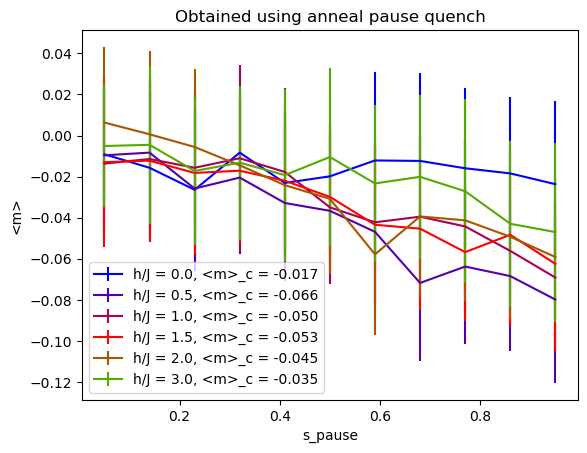

In [156]:
#sort the h1list
sorted_hs = np.array([float(h1list[i]) for i in range(len(h1list))])
sort_index = np.argsort(sorted_hs)

colors = len(list_of_folders)
cmap = matplotlib.cm.get_cmap('brg')

some_k = range(len(list_of_folders))
#some_k = [0]
for k in some_k:
    h1_print_val = h1list[sort_index[k]]
    file_name = where_to_save + "processed_h=" + h1_print_val + ".hdf5"
    data = h5py.File(file_name, 'r')
    xval = data['slist']
    yval = np.mean(data['good_down_triangle_magnetization'], axis = 1) 
    avg_classical_mag = np.mean(yval[-3:-1])
    #yval = yval - avg_classical_mag
    
    error = np.std(data['good_down_triangle_magnetization'], axis = 1)
    #plt.plot(xval, yval, label = 'h/J = ' + str(float(h1_print_val)*1.5120125550062011))
    rgba = cmap(k/len(list_of_folders))
    plt.errorbar(xval, yval, yerr = error, label = 'h/J = ' + str(float(h1_print_val)*1.5120125550062011) + ', <m>_c = {0:.3f}'.format(avg_classical_mag), color = rgba)
plt.legend()
plt.xlabel('s_pause')
plt.ylabel('<m>')
#plt.ylim((-1,0))
plt.title('Obtained using anneal pause quench')
plt.show()


# plot with the Gamma/J

In [83]:
data = pd.read_excel('./annealing_schedule.xlsx',  sheet_name='processor-annealing-schedule') 
s_vals = pd.DataFrame(data, columns=['s'])
A_vals = pd.DataFrame(data, columns=['A(s) (GHz)'])
B_vals = pd.DataFrame(data, columns=['B(s) (GHz)'])
cs_vals = pd.DataFrame(data, columns=['C (normalized)'])
first_s = s_vals.to_numpy().flatten()
first_A = A_vals.to_numpy().flatten()
first_B = B_vals.to_numpy().flatten()
first_c = cs_vals.to_numpy().flatten()

new_s = np.linspace(0,1,num = 100*len(first_s))
new_A = np.interp(new_s, first_s, first_A)
new_B = np.interp(new_s, first_s, first_B)
new_c = np.interp(new_s, first_s, first_c)

AdivB = np.divide(new_A,new_B)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    

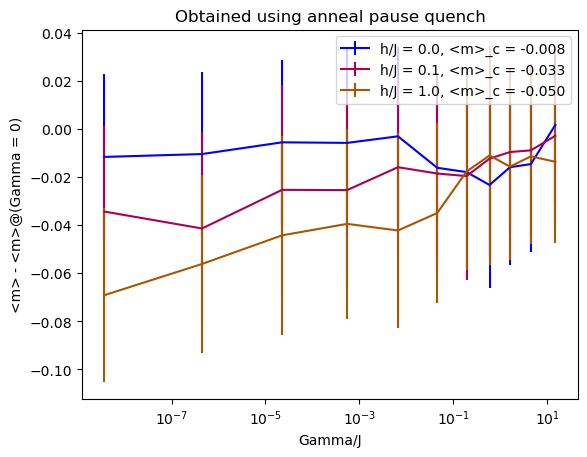

In [149]:
#sort the h1list
sorted_hs = np.array([float(h1list[i]) for i in range(len(h1list))])
sort_index = np.argsort(sorted_hs)
overJ = 1.5120125550062011

for k in range(len(list_of_folders)):
    h1_print_val = h1list[sort_index[k]]
    file_name = where_to_save + "processed_h=" + h1_print_val + ".hdf5"
    data = h5py.File(file_name, 'r')
    xval_s = data['slist']

    xval_gammaoverJ = np.zeros(len(xval_s))
    for i in range(len(xval_s)):
        index_s = find_nearest(new_s, value = xval_s[i])
        xval_gammaoverJ[i] = overJ*AdivB[index_s]


    yval = np.mean(data['good_down_triangle_magnetization'], axis = 1) 
    avg_classical_mag = np.mean(yval[-3:-1])
    #yval = yval - avg_classical_mag
    error = np.std(data['good_down_triangle_magnetization'], axis = 1)
    #plt.plot(xval, yval, label = 'h/J = ' + str(float(h1_print_val)*1.5120125550062011))
    rgba = cmap(k/len(list_of_folders))
    plt.errorbar(xval_gammaoverJ, yval, yerr = error, label = 'h/J = ' + str(float(h1_print_val)*1.5120125550062011) + ', <m>_c = {0:.3f}'.format(avg_classical_mag), color = rgba)
plt.legend()
plt.xlabel('Gamma/J')
plt.xscale('log')
plt.ylabel('<m> - <m>@(Gamma = 0)')
#plt.ylim((-1,0))
plt.title('Obtained using anneal pause quench')
plt.show()